This notebook goes through the process on how to do various **boolean operations**.

# IMPORTS

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go

from spomso.cores.helper_functions import generate_grid, smarter_reshape
from spomso.cores.post_processing import hard_binarization
from spomso.cores.geom_2d import NGon
from spomso.cores.geom_3d import Box, Cylinder, Arc3D
from spomso.cores.combine import CombineGeometry

# PARAMETERS

In [2]:
# size of the volume
co_size = 3, 3, 1.6
# resolution of the volume
co_resolution = 200, 200, 100

show = "FIELD" # BINARY, FIELD
show_midplane = True
show_3d = False

# COORDINATE SYSTEM

Point cloud of coordinates is created with the **generate_grid** function, which takes the size of the coordinate system and the number of points in each direction (**co_resolution**).

In [3]:
coor, co_res_new = generate_grid(co_size, co_resolution)

If there is an even number of points along any direction the function will automatically convert it to an odd number, therefore the origin is always included in the point cloud. The point cloud is a numpy.ndarray with a shape of **(D, N)**, where **D** is the number of dimensions and **N** is the number of data points.

# CREATE SDFs

## Main Body

Create a **box** with side lengths **3**, **1**, and **0.5**:

In [4]:
box = Box(3, 1, 0.5)

## Hex Rod

Create a **hexagon** with **radius** of **0.3**:

In [5]:
hexagon = NGon(0.3, 6)

Convert the shape into a line:

In [6]:
hexagon.boundary()

<function spomso.cores.modifications.ModifyObject.boundary.<locals>.new_geo_object(co, *params)>

create two **concentric** lines with a separation of **0.2**:

In [7]:
hexagon.concentric(0.2)

<function spomso.cores.modifications.ModifyObject.concentric.<locals>.new_geo_object(co, *params)>

Give the **lines** a thickness of **0.05**:

In [8]:
hexagon.rounding(0.05)

<function spomso.cores.modifications.ModifyObject.rounding.<locals>.new_geo_object(co, *params)>

**Extrude** the shape along the **z-axis** for **2** units:

In [9]:
hexagon.extrusion(2)

<function spomso.cores.modifications.ModifyObject.extrusion.<locals>.new_geo_object(co, *params)>

Position the **hexagon**:

In [10]:
hexagon.move((0.5, 0, 0))

## Round Rod

Create a **cylinder** with **radius** of **0.4** and **height** of **1**:

In [11]:
cy = Cylinder(0.4, 1)

**Position** the **cylinder**:

In [12]:
cy.move((-0.5, 0, 0))

**Rotate** the **cylinder** for **30°** around the **x-axis**:

In [13]:
cy.rotate(np.pi/6, (0, 1, 0))

## Arc

Create an **arc** in 3D with the **radius** of **1**, **thickness** of **0.1**. The endpoints are at angles **45°** and **315°**:

In [14]:
arc = Arc3D(1, 0.2, np.pi/4, 7*np.pi/4)

## Round Rod 2

Create a **cylinder** with **radius** of **1.2** and **height** of **1**:

In [15]:
cya = Cylinder(1.2, 1)

## Combine Objects

Define **union**, **subtract** and **intersect** operations:

In [16]:
union = CombineGeometry("UNION")
subtract = CombineGeometry("SUBTRACT2")
intersect = CombineGeometry("INTERSECT2")

**Merge (union)** the **box** and the **arc** into geometry **s1** and **merge** the **hexagon** and the **cylinder** into geometry **s2**. The **s1** geometry will be the **base** from which **s2** geometry is **subtracted**.

In [17]:
s1 = union.combine(box, arc)
s2 = union.combine(hexagon, cy)

**Subtract** geometry **s2** from geometry **s1**:

In [18]:
s3 = subtract.combine(s1, s2)

By intersecting the geometries of **s3** and the **large cylinder (cya)** the edges of the **box** are rounded:

In [19]:
s4 = intersect.combine(s3, cya)

## EVALUATE

Evaluate the SDF of the **final shape** to create a signed distance field 3D map. This is done by calling the **create** method and passing in the point cloud of coordinates:

In [20]:
combined_pattern = s4.create(coor)

# BINARIZATION

Convert the distance field to a binary voxel map, where 1 corresponds to the interior and 0 to the exterior of the geometry.

In [21]:
if show_midplane:
    field = smarter_reshape(combined_pattern, co_resolution)
    if show=="BINARY":
        pattern_2d = hard_binarization(field, 0)

if show=="BINARY":
    pattern = hard_binarization(combined_pattern, 0)

# PLOT

Drawing results...


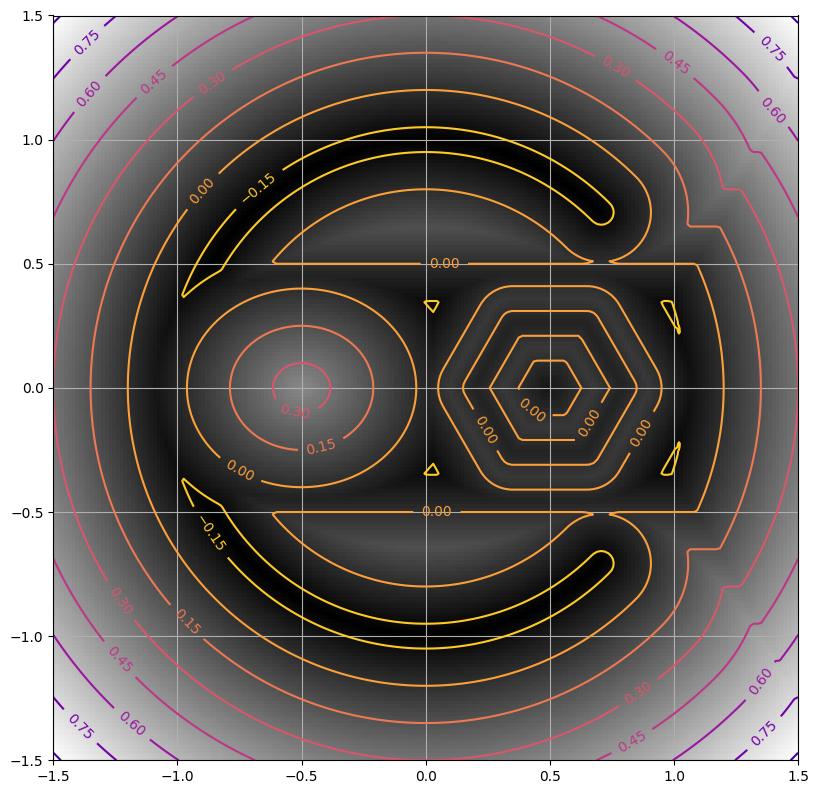

In [22]:
print("Drawing results...")
# Mid-plane cross-section plot
if show_midplane and show=="BINARY":
    fig, ax = plt.subplots(1,1, figsize=(8.25, 8.25))
    ax.imshow(pattern_2d[:, :,  co_resolution[2]//2].T,
              cmap="binary_r",
              extent=(-co_size[0]/2, co_size[0]/2,
                      -co_size[1]/2, co_size[1]/2),
              origin="lower"
              )
    ax.grid()

    fig.tight_layout()
    plt.show()

if show_midplane and show == "FIELD":
    fig, ax = plt.subplots(1, 1, figsize=(8.25, 8.25))
    ax.imshow(field[:, :,  co_resolution[2]//2].T,
              cmap="binary_r",
              extent=(-co_size[0] / 2, co_size[0] / 2,
                      -co_size[1] / 2, co_size[1] / 2),
              origin="lower"
              )
    z_mask = coor[2] == 0
    cs = ax.contour(coor[0, z_mask].reshape(co_res_new[0], co_res_new[1]),
                    coor[1, z_mask].reshape(co_res_new[0], co_res_new[1]),
                    field[:, :,  co_resolution[2]//2],
                    cmap="plasma_r")
    ax.clabel(cs, inline=True, fontsize=10)
    ax.grid()

    fig.tight_layout()
    plt.show()

In [23]:
# Isosurfaces plot
if show_3d and show=="BINARY":
    fig = go.Figure(data=go.Volume(
        x=coor[0],
        y=coor[1],
        z=coor[2],
        value=pattern,
        isomin=0.1,
        isomax=1,
        opacity=0.1,
        surface_count=2,
    ))
    fig.show()

if show_3d and show=="FIELD":
    fig = go.Figure(data=go.Volume(
        x=coor[0],
        y=coor[1],
        z=coor[2],
        value=combined_pattern,
        isomin=-0,
        isomax=0.5,
        opacity=0.1,
        surface_count=5,
    ))
    fig.show()
